### Import libraries, data, viz data

Using device: cuda
Example images of CIFAR-10 dogs


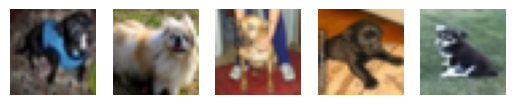

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import SGD  # Our chosen optimizer
from torch.utils.data import DataLoader, TensorDataset
from nets import UNet

def show_image(xs):
    """Display a list of CIFAR-10 images in a table.
    Images may be flattened or unflattened.
    Assumes floats in range [0,1] representing colors"""
    xs = xs.cpu()
    n = len(xs)
    fig, axs = plt.subplots(1, n)
    for i, ax in enumerate(axs):
        x = xs[i].reshape(3, 32, 32).moveaxis(0, -1)
        x = torch.clamp(x, 0., 1.)
        ax.imshow(x)
        ax.axis('off')
    return fig

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

# datasets are small enough to be loaded on GPU
dogs_train, dogs_val = torch.load('hw3_data.pt', map_location=device)
val_loader = DataLoader(TensorDataset(dogs_val), batch_size=50, drop_last=True)

def test_model(model, val_loader=val_loader):
    """Code to test MSE on validation data."""
    criterion = nn.MSELoss()
    model.eval()
    mse = 0.
    with torch.no_grad():
        for x, in val_loader:
            x_noise = x + 0.1 * torch.randn_like(x)
            x_hat = model(x_noise).view(x.shape)
            mse += criterion(x, x_hat) / len(val_loader)
    return mse

print("Example images of CIFAR-10 dogs")
fig = show_image(dogs_train[:5])

# Linear Dog Denoiser

We will use PCA to define a linear denoiser.
First, we encode the data into a latent factor using the top 500 principal components, then we decode to recover a (denoised) version of the image that lies on the linear subspace spanned by the first 500 components.
I found it convenient to put a "flatten" operation inside fit and forward, so I could just input the images directly with the same shape as for the UNet.

In [ ]:
class LinearDenoiser(nn.Module):
    """Denoise by projecting onto linear subspace spanned by
    top principal components."""
    def __init__(self, d=500):
        super(LinearDenoiser, self).__init__()
        self.d = d  # Number of principal components to use
        self.mu = None
        self.n = None
        self.U = None
        self.S = None

    def forward(self, x):
        x = x.flatten(start_dim=1)  # Flatten images to vectors
        z = self.encode(x)
        x_hat = self.decode(z)
        x_hat = x_hat.reshape(-1, 3, 32, 32)  # Unflatten back to image
        return x_hat

    def encode(self, x):
        # Encode x into low-d latent space
        z = torch.mm(x - self.mu, self.U[:, :self.d])
        return z

    def decode(self, z):
        # linearly decode back to x-space
        x_hat = torch.mm(z, self.U[:, :self.d].t()) + self.mu
        return x_hat

    def fit(self, x):
        # Use PCA to get the parameters
        x = x.flatten(start_dim=1)
        # store the mean to center data and for reconstruction.
        self.mu = x.mean(dim=0)
        self.n = len(x)
        # Use SVD to get eigenvectors of covariance
        cov = x - self.mu
        cov = torch.mm(cov.t(), cov) / self.n
        self.U, self.S, U_copy = torch.svd(cov)

linear_model = LinearDenoiser()
linear_model.fit(dogs_train)

In [ ]:
linear_model = LinearDenoiser()
linear_model.fit(dogs_train)

test_batch = dogs_train[:10]
flat_test_batch = test_batch.flatten(start_dim=1)
z = linear_model.encode(flat_test_batch)
_, k = z.shape
x_hat = linear_model.decode(z)
_, d = x_hat.shape
x_hat_forward = linear_model(test_batch)
assert d == 3072, 'x_hat size should be 32*32*3'
assert k == linear_model.d, 'Encoded signal size is wrong'
assert x_hat_forward.shape == test_batch.shape
print('all tests passed')

all tests passed


### Train U-Net
Use the included U-Net, and train it to denoise images
by minimizing the Mean Square Error loss (nn.MSELoss) between images and reconstructions from a noisy version of the image.
Use a noise standard deviation of 0.1 for the Gaussian noise.
Train with SGD.

In [ ]:
def train(model, train_loader, val_loader, n_epochs, optimizer, criterion, verbose=False):
    """Train model using data from train_loader over n_epochs,
    using a Pytorch "optimizer" object (SGD in this case) 
    and "criterion" as the loss function (CrossEntropyLoss in this case). 
    """
    model.train()
    for _ in range(n_epochs):
        for y_batch, in train_loader:
            model.zero_grad()
            x_batch = y_batch + 0.1 * torch.randn_like(y_batch)
            y_hat = model(x_batch)
            loss = criterion(y_hat, y_batch)
            loss.backward()
            optimizer.step()

        if verbose:
            # Validation loop
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for y_batch, in val_loader:
                    x_batch = y_batch + 0.1 * torch.randn_like(y_batch)
                    y_hat = model(x_batch)
                    loss = criterion(y_hat, y_batch)
                    val_loss += loss.item()/len(val_loader)
            model.train()
            # Print out train/val loss during development
            print(f'Epoch \t{_}, Validation loss \t{val_loss:.3f}')

In [ ]:
# Train the UNet.

model = UNet().to(device)

n_epochs = 20
optimizer = SGD(model.parameters(), lr = 0.01)
criterion = nn.MSELoss()
train_loader = DataLoader(TensorDataset(dogs_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(dogs_val), batch_size=32, shuffle=True)
train(model, train_loader, val_loader, n_epochs, optimizer, criterion, verbose=False)

###  Results

Original images


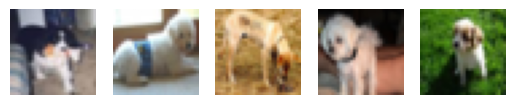

Noisy images


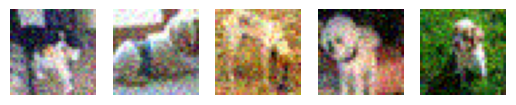

Linear denoising


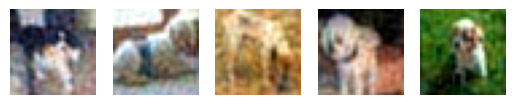

UNet denoising


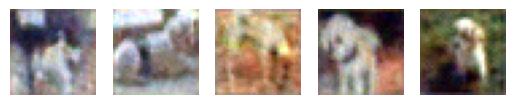

Linear model Val MSE: 0.0026
UNet Val MSE: 0.0053


In [ ]:
dogs = dogs_val[:5].cpu()
noisy_dogs = dogs + 0.1 * torch.randn_like(dogs)
with torch.no_grad():
    linear_denoise = linear_model(noisy_dogs.to(device)).cpu()
    unet_denoise = model(noisy_dogs.to(device)).cpu()

print("Original images")
show_image(dogs)
plt.show()
print("Noisy images")
show_image(noisy_dogs)
plt.show()
print("Linear denoising")
show_image(linear_denoise)
plt.show()
print("UNet denoising")
show_image(unet_denoise)
plt.show()

linear_mse = test_model(linear_model)
unet_mse = test_model(model)
print(f"Linear model Val MSE: {linear_mse:.4f}")
print(f"UNet Val MSE: {unet_mse:.4f}")